__Note__: In order to run the notebooks from this directory you need to have  "... UVwork/uvnn" directory into python path, For example my project path is `/Users/johndoe/Projects/UVwork/uvnn` Then on
* linux: you put this in your __.bashrc__ file: `export PYTHONPATH=$PYTHONPATH:/Users/zisakadze/Projects/UVwork/uvnn`
* windows : http://stackoverflow.com/questions/3701646/how-to-add-to-the-pythonpath-in-windows-7

If done correctly you should be able to execute `import uvnn` from this notebook.


In [20]:
# Set up and load modules nothing special here
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext autotime

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['savefig.dpi'] = 100

## Our modules

from uvnn.utils.readers import CsvReader
from uvnn.clfpipeline import Clfpipeline
from uvnn.classifiers.mlp import MLP
from uvnn.classifiers.misc import merge_dicts
from uvnn.utils.images import show_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.71 ms


### Download the mnist [data](https://www.kaggle.com/c/digit-recognizer/data), train.csv, test.sv and put them into input/kaggle_mnist/ directory

In [12]:
from uvnn.utils.preprocessors import MnistPP # Mnist preprocessor 
csv_reader = CsvReader(fn='../input/kaggle_mnist/train.csv',has_header=True, label_pos=0)
pipe = Clfpipeline(csv_reader, PreProc=MnistPP, load_now=True)

X_train shape (33600, 784)
X_dev shape (4200, 784)
X_test shape (4200, 784)
(4200, 784) (4200, 784)
time: 6.79 s


you could see the result when the train loss reaches __8__, it takes ~8mn on my machine

Begin SGD...
  Seen 0 in 0.00 s
Jsparsity 73.7879684131
Jsparsity 73.764366524
  [0]: mean train loss 81.4111 mean valid loss 81.2445
Jsparsity 0.0783321357905
Jsparsity 0.0990889282722
  [50]: mean train loss 31.2085 mean valid loss 31.1943
Jsparsity 0.218926289865
Jsparsity 0.258047621732
  [100]: mean train loss 20.9769 mean valid loss 21.0413
Jsparsity 0.220492012035
Jsparsity 0.255327774712
  [150]: mean train loss 15.7707 mean valid loss 15.9206
Jsparsity 0.120162988526
Jsparsity 0.147143645795
  [200]: mean train loss 12.9668 mean valid loss 13.0864
Jsparsity 0.0598693846158
Jsparsity 0.0757552058612
  [250]: mean train loss 11.1355 mean valid loss 11.2414
Jsparsity 0.111170373659
Jsparsity 0.129475421223
  [300]: mean train loss 9.74201 mean valid loss 9.879
Jsparsity 0.0736068382936
Jsparsity 0.0921018120031
  [350]: mean train loss 8.82012 mean valid loss 8.94002
Jsparsity 0.0712823374979
Jsparsity 0.0870533124909
  [400]: mean train loss 8.29828 mean valid loss 8.4309
SGD In

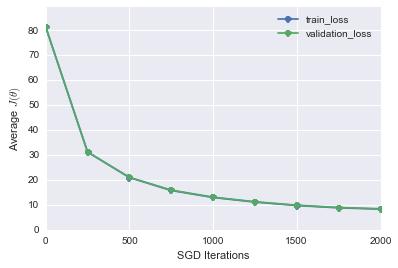

time: 7min 44s


In [15]:
from uvnn.classifiers.autoencoder_sparse import AutoEncoderSparse
from uvnn.utils.preprocessors import AutoEncoderPP
conf_clf = {'dims':(784, 196, 784), 
            'alpha':0.001,
            #'alpha':0.000095, 
            'reg':0.0000,
            'beta':3,  # sparsity loss weight
            'ro':0.1}  # sparsity parameters, average hidden activation for each neuron
conf_train = {'batchsize':600, 
              'costevery': 50, # After how many iterations to evaluate on whole train and test data 
              'nepoch': 5000,   # 
              'acc_batch':True,
              'opt':'rmsprop',
              'loss_metric':'MSE',
              'tolerance':-1}   # if you want to stop automatically setting to 0.1 will cause to stop when the loss in the last few iteration won't improve by 0.1 
fullconf = merge_dicts(conf_clf, conf_train)
#aec = AutoEncoderSparse(**conf_clf)
#aec.grad_check(pipe.X[0], pipe.X[0])
pipe.set_classifier(AutoEncoderSparse(**conf_clf))
pipe.train(**conf_train)
pipe.plot()

### We can visualize how sparse autoencoder predicts digits
First row is the input, second row is the output of the AE

In [26]:
predicted_images.shape

(10, 784)

time: 2.4 ms


preprocessed data shape (42000, 784)


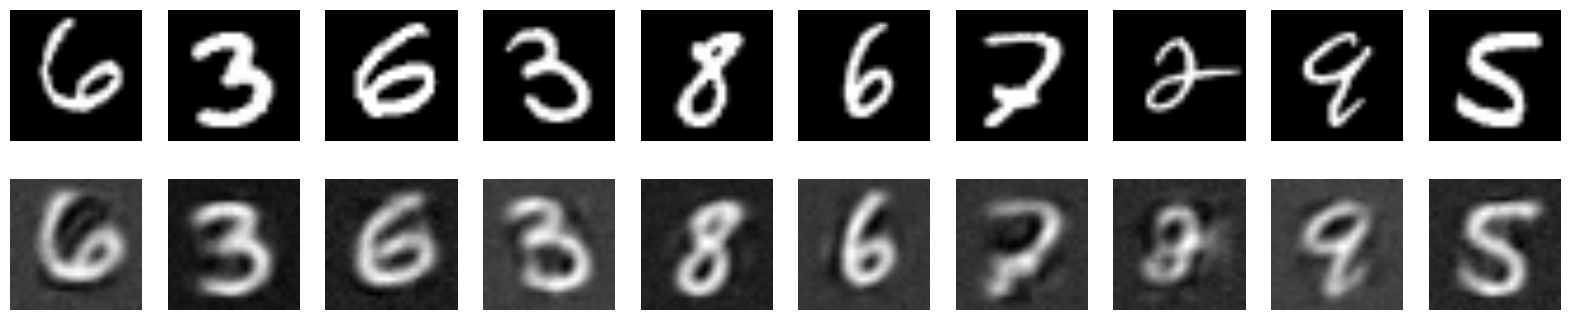

time: 1.9 s


In [39]:
n_images = 10
X = pipe.preprocessor.X
print 'preprocessed data shape', X.shape
orig_images = X[:n_images, :]
predicted_images = pipe.classifier.predict(orig_images)
show_images(np.concatenate((orig_images, predicted_images), axis=0), 28, 28)

In [18]:
# We could save the weights
pipe.save_weights(algo_name="AE_EXAMPLE", dataset_name="KAGGLEMNIST", confs=fullconf, folder="../output/")

descript filename ../output/AE_EXAMPLE_KAGGLEMNIST_DESC.txt
['# AE_EXAMPLE for KAGGLEMNIST DATASET', '# SPLITS(train, val, test) 0.800, 0.100, 0.100']
weight filename ../output/AE_EXAMPLE_KAGGLEMNIST_weights_1.txt
weight filename ../output/AE_EXAMPLE_KAGGLEMNIST_weights_2.txt
time: 280 ms


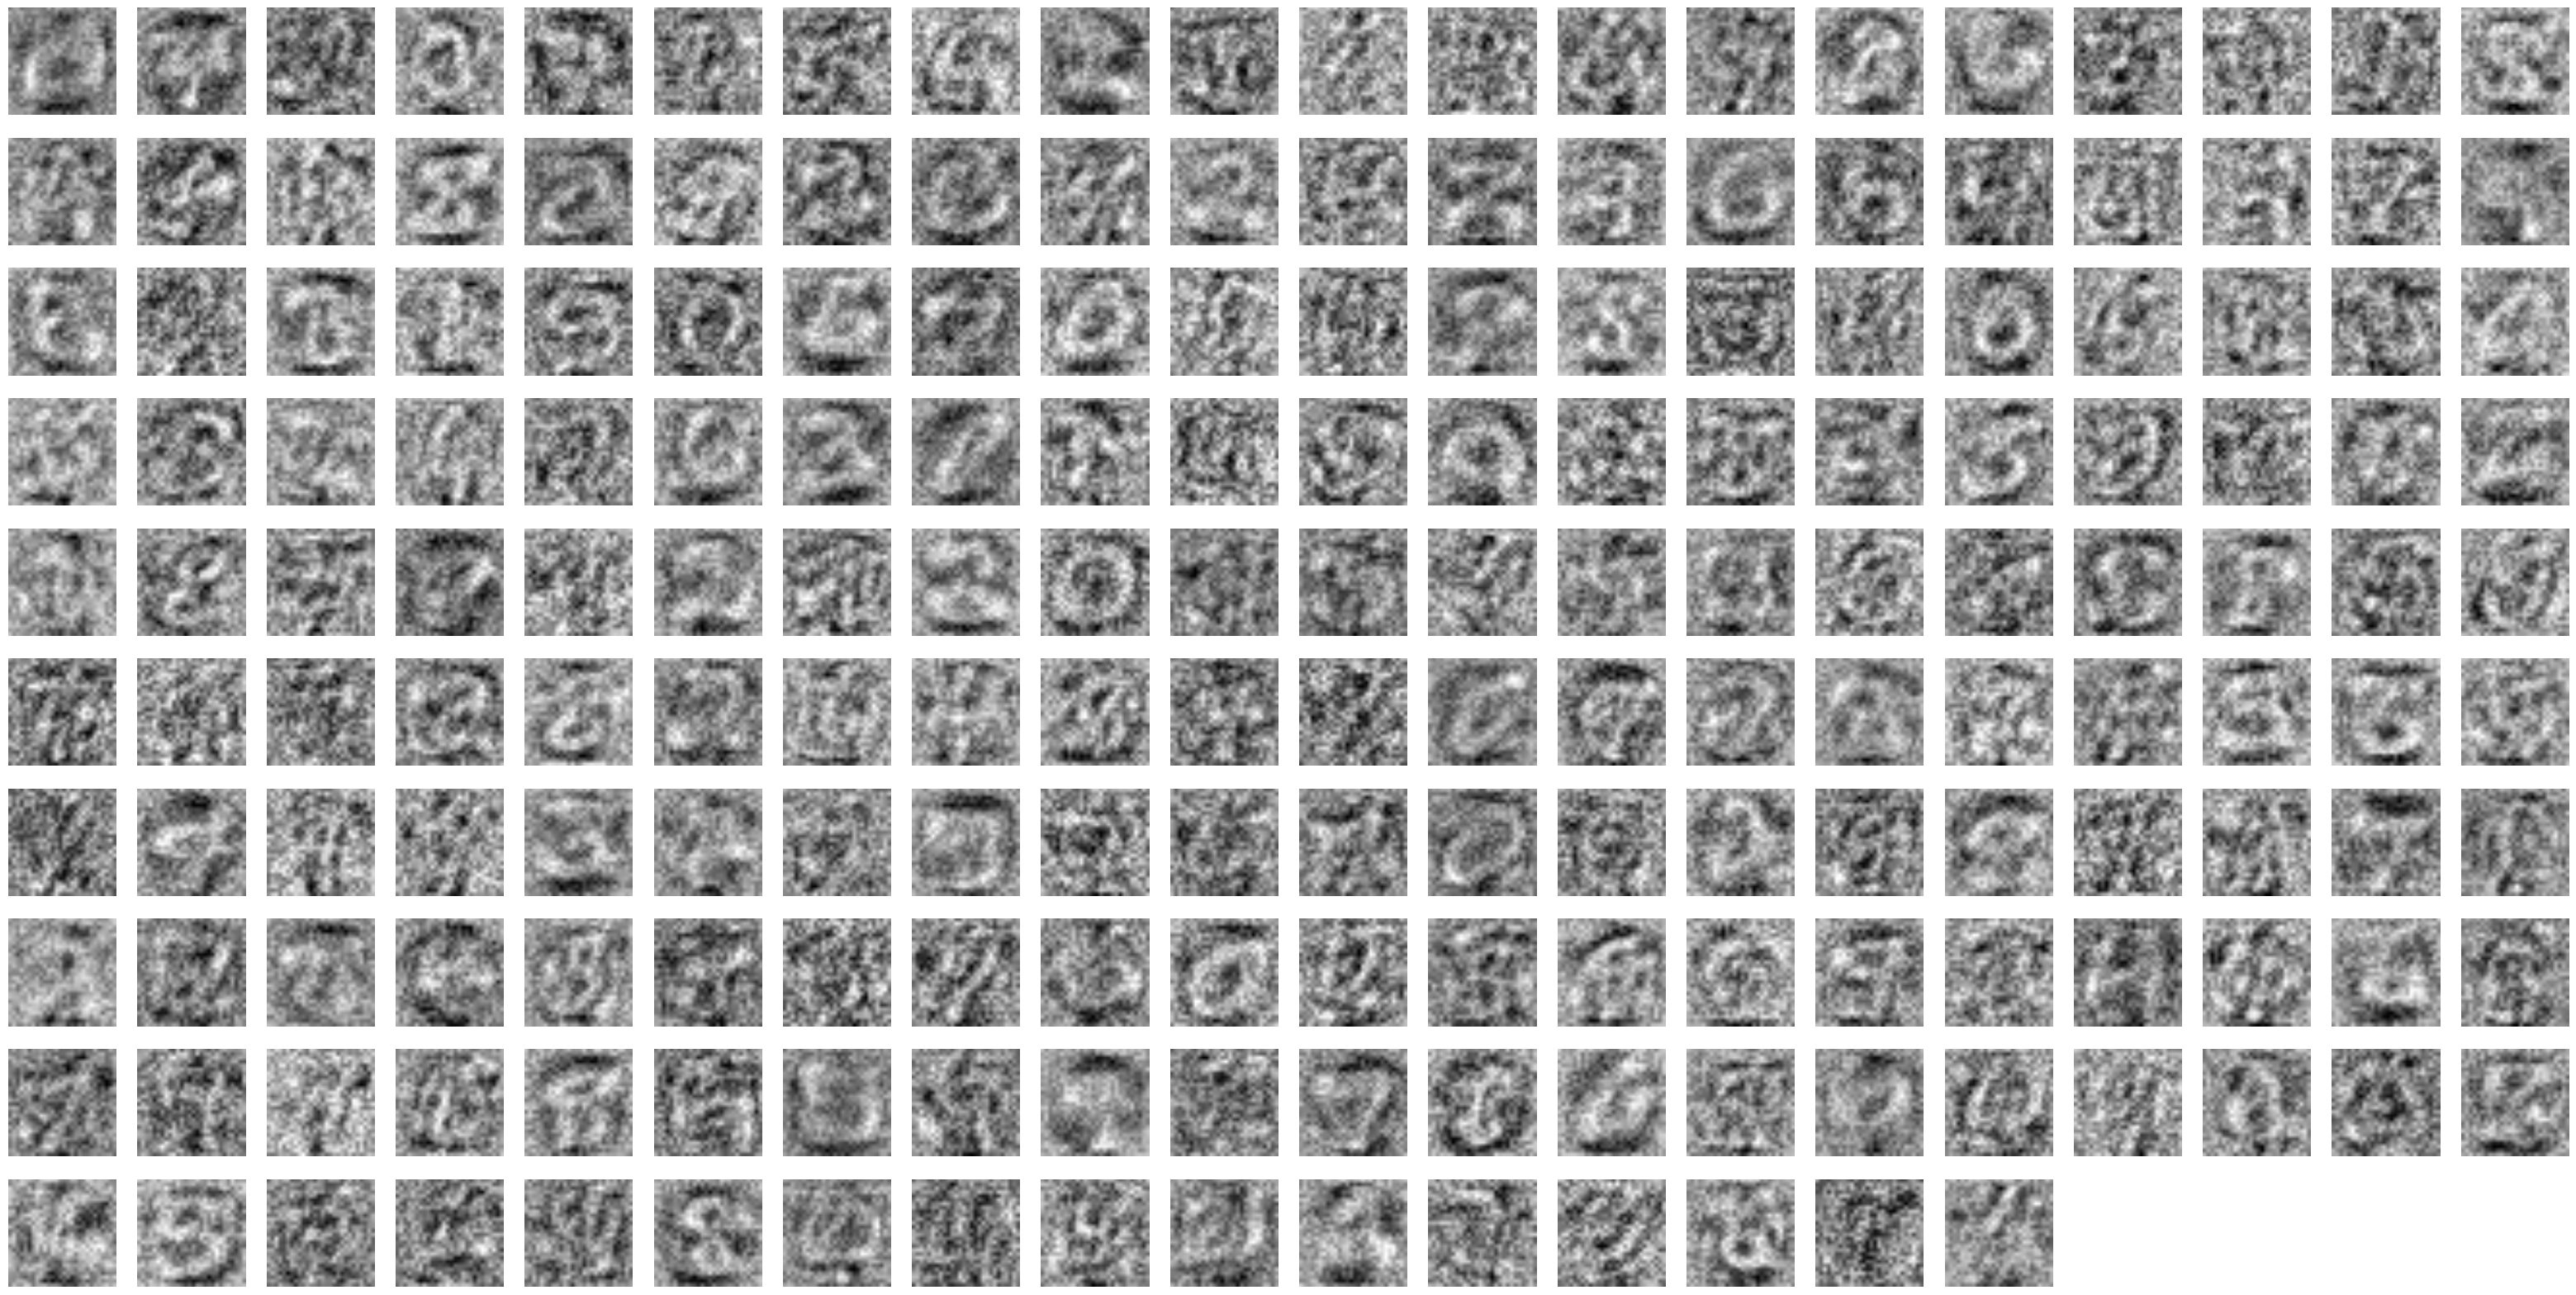

time: 15.7 s


In [34]:
# Now get autoencoder weights and visualize them
weights = pipe.classifier.get_weights()[0][:,:-1] # first index is needed to get the first layer weight, second to drop bias
show_images(weights, 28, 28, 20)

In [40]:
# to get the hidden activations we can call 
hidden = pipe.classifier.predict_hidden(X)
print 'hidden shape', hidden.shape

hidden shape (42000, 196)
time: 4.25 s
